In [1]:
import torch as tc
import torch.nn as nn

In [4]:
import numpy as np

In [34]:
import matplotlib.pyplot as plt

In [6]:
class PINN(nn.Module):
    def __init__(self, hidden_dim: int, num_layers: int):
        super().__init__()
        layers = [nn.Linear(2, hidden_dim), nn.Tanh()]
        for _ in range(num_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x, t):
        inputs = tc.cat([x,t], dim=1)
        return self.network(inputs)

In [57]:
def pde_residual(model, x, t):
    x = x.requires_grad_(True)
    t = t.requires_grad_(True)
    u = model(x,t)

    u_t = tc.autograd.grad(
        u,
        t,
        grad_outputs=tc.ones_like(u),
        create_graph=True
    )[0]

    u_x = tc.autograd.grad(
        u,
        x,
        grad_outputs=tc.ones_like(u),
        create_graph=True
    )[0]

    u_xx = tc.autograd.grad(
        u_x,
        x,
        grad_outputs=tc.ones_like(u),
        create_graph=True
    )[0]

    residual = u_t - u_xx
    return residual

In [58]:
def train_step(model, optimizer, x_ic, u_ic, x_bc, t_bc, x_pde, t_pde):
    optimizer.zero_grad()

    t_ic = tc.zeros_like(x_ic)
    u_pred_ic = model(x_ic, t_ic)
    ICLoss = nn.MSELoss()(u_pred_ic, u_ic)

    u_pred_bc = model(x_bc, t_bc)
    BCLoss = nn.MSELoss()(u_pred_bc, tc.zeros_like(u_pred_bc))

    residual = pde_residual(model, x_pde, t_pde)
    ResidualLoss = tc.mean(residual**2)

    loss = ICLoss + BCLoss + ResidualLoss
    loss.backward()
    optimizer.step()
    return loss.item()


In [59]:
def initial_condition(x):
    return np.sin(np.pi * x)

N_ic, N_bc, N_pde = 100, 100, 1000

t_end = 0.1

model = PINN(64, 4)
optimizer = tc.optim.Adam(model.parameters(), lr=1e-3)
scheduler = tc.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=5, factor=0.5
)

for epoch in range(500):
    model.train()
    train_loss = 0
    #Initial condition, for unspecified function initial_condition(), definition above is a placeholder
    x_ic = tc.rand(N_ic, 1)
    u_ic = tc.tensor([[initial_condition(x.item())] for x in x_ic], dtype = tc.float32)

    #Boundary
    x_bc = tc.cat([tc.zeros(N_bc//2, 1), tc.ones(N_bc//2, 1)])
    t_bc = tc.rand(N_bc, 1)

    x_pde = tc.rand(N_pde, 1)
    t_pde = tc.rand(N_pde, 1)*t_end

    t_bc_norm = t_bc / t_end
    t_pde_norm = t_pde / t_end

    train_loss += train_step(model, optimizer, x_ic, u_ic, x_bc, t_bc_norm, x_pde, t_pde_norm)

    scheduler.step(train_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1} | Loss: {train_loss:.6f}")

Epoch 10 | Loss: 0.165006
Epoch 20 | Loss: 0.138645
Epoch 30 | Loss: 0.127450
Epoch 40 | Loss: 0.134455
Epoch 50 | Loss: 0.131104
Epoch 60 | Loss: 0.135523
Epoch 70 | Loss: 0.107306
Epoch 80 | Loss: 0.102791
Epoch 90 | Loss: 0.102413
Epoch 100 | Loss: 0.128896
Epoch 110 | Loss: 0.124849
Epoch 120 | Loss: 0.137815
Epoch 130 | Loss: 0.151319
Epoch 140 | Loss: 0.122372
Epoch 150 | Loss: 0.124187
Epoch 160 | Loss: 0.124787
Epoch 170 | Loss: 0.112796
Epoch 180 | Loss: 0.117926
Epoch 190 | Loss: 0.120878
Epoch 200 | Loss: 0.134964
Epoch 210 | Loss: 0.111887
Epoch 220 | Loss: 0.121352
Epoch 230 | Loss: 0.134362
Epoch 240 | Loss: 0.130389
Epoch 250 | Loss: 0.121126
Epoch 260 | Loss: 0.125317
Epoch 270 | Loss: 0.120881
Epoch 280 | Loss: 0.138963
Epoch 290 | Loss: 0.106882
Epoch 300 | Loss: 0.121390
Epoch 310 | Loss: 0.133320
Epoch 320 | Loss: 0.136559
Epoch 330 | Loss: 0.113386
Epoch 340 | Loss: 0.118527
Epoch 350 | Loss: 0.142359
Epoch 360 | Loss: 0.141036
Epoch 370 | Loss: 0.117427
Epoch 380 

In [10]:
def analytical_solution(x, t):
    return np.sin(np.pi * x)*np.exp(-(np.pi**2)*t)

In [15]:
x_test = np.linspace(0,1,64)

ana_solution = np.zeros((64, 3))

for i in range(64):
    ana_solution[i, 0] = analytical_solution(x_test[i], 0.01)
    ana_solution[i, 1] = analytical_solution(x_test[i], 0.05)
    ana_solution[i, 2] = analytical_solution(x_test[i], 0.1)

In [60]:
x_test_tensor = tc.tensor(x_test, dtype=tc.float32).unsqueeze(dim=-1)
t1 = 0.01*tc.ones_like(x_test_tensor)/t_end
t2 = 0.05*tc.ones_like(x_test_tensor)/t_end
t3 = 0.1*tc.ones_like(x_test_tensor)/t_end

In [61]:
pinn_solution = np.zeros((64, 3))
model.eval()
with tc.no_grad():
    pinn_solution[:,0] = model(x_test_tensor, t1.to(tc.float32)).detach().numpy()[:,0]
    pinn_solution[:,1] = model(x_test_tensor, t2.to(tc.float32)).detach().numpy()[:,0]
    pinn_solution[:,2] = model(x_test_tensor, t3.to(tc.float32)).detach().numpy()[:,0]

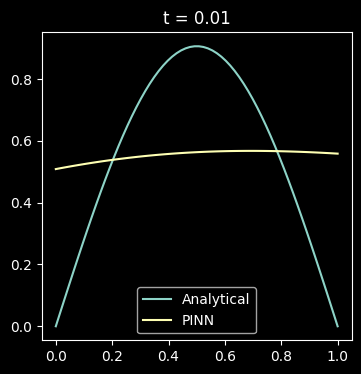

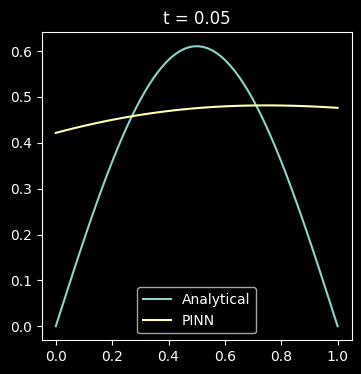

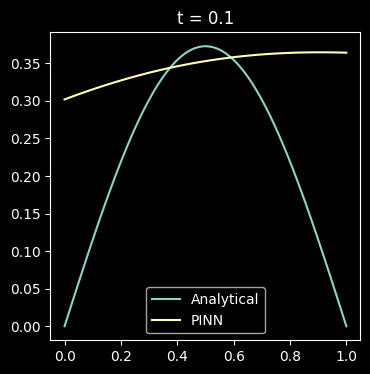

In [62]:
fig1, ax1 = plt.subplots(figsize=(4,4))

ax1.plot(x_test, ana_solution[:,0], label='Analytical')
ax1.plot(x_test, pinn_solution[:,0], label='PINN')

ax1.legend()
ax1.set_title('t = 0.01')
plt.show()

fig2, ax2 = plt.subplots(figsize=(4,4))

ax2.plot(x_test, ana_solution[:,1], label='Analytical')
ax2.plot(x_test, pinn_solution[:,1], label='PINN')

ax2.legend()
ax2.set_title('t = 0.05')
plt.show()

fig3, ax3 = plt.subplots(figsize=(4,4))

ax3.plot(x_test, ana_solution[:,2], label='Analytical')
ax3.plot(x_test, pinn_solution[:,2], label='PINN')

ax3.legend()
ax3.set_title('t = 0.1')
plt.show()